# Microbatch training

When training is performed by gradient descent or its modifications it is not enough GPU memory often to compute gradients on large batch (for example, of size 1024). One of the ways to overcome this obstacle is to divide batch into small microbatches, compute gradients on each microbatch and then accumulate gradients and apply gradients on the whole batch.

In [1]:
import sys
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from microbatch import load, define_model, train_on_batch

%matplotlib inline

Consider classification task of MNIST. Demonstrate how execution time changes depending on microbatch size.

In [2]:
MNIST_SIZE = 10000
N_EPOCHS = 2
BATCH_SIZE = 1024
N_ITER = MNIST_SIZE // BATCH_SIZE

In [3]:
# загрузка данных
images, labels = load(MNIST_SIZE)

# определим tf модель (3 свёрточных слоя, 2 полносвязных)
session, x_ph, y_ph, set_zero, accum_op, train_op, loss = define_model()

# рассмотрим микробатчи размера, кратного BATCH_SIZE (1,2,4,...)
grid = np.arange(1,BATCH_SIZE+1)[(BATCH_SIZE % np.arange(1,BATCH_SIZE+1)) == 0]
times_per_iter = []

for micro_batch_size in grid:
    times = []
    rams = []
    ix = np.arange(len(images))
    for ep in tqdm(range(N_EPOCHS)):
        np.random.shuffle(ix)
        for it in range(N_ITER):
            indices = ix[it * BATCH_SIZE: (it + 1) * BATCH_SIZE]
            batch_x = images[indices]
            batch_y = labels[indices]
            time_it= train_on_batch(session, 
                                    [x_ph, y_ph], 
                                    [batch_x, batch_y], 
                                    micro_batch_size, 
                                    set_zero, 
                                    accum_op, 
                                    train_op)
            times.append(time_it)
    times_per_iter.append(times)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.05it/s]


In [5]:
time_per_iter = np.mean(np.array(times_per_iter), axis=1)

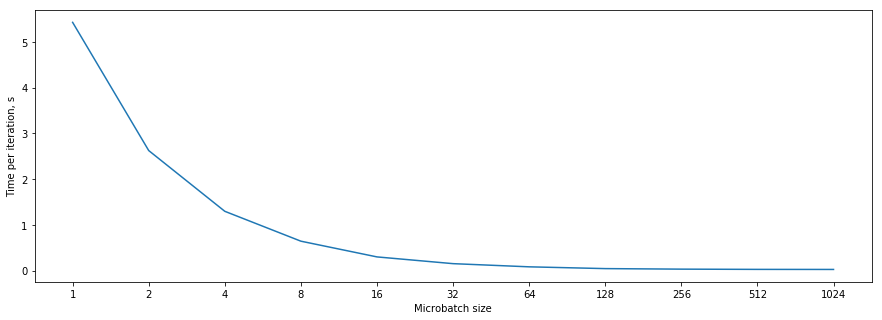

In [6]:
plt.figure(figsize = (15,5))
plt.plot(time_per_iter)
plt.xticks(range(len(grid)), grid)
plt.xlabel('Microbatch size')
plt.ylabel('Time per iteration, s')
plt.show()